# Validation model
Test and experiments to check the performance of one or more models

In [2]:
import matplotlib.pyplot as matPlt
import random
import numpy as np

import tensorflow as tf
import keras
from keras import layers
from tqdm.keras import TqdmCallback

import math
from shapely.geometry import Polygon

import rasterio
from rasterio import plot as rastPlt
from rasterio.mask import mask as rasterMask

import junodch_utils_read_img as utils

## Fetch data from the test region

In [5]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night_VIIRS.tif"
pathValidation = folderName + "Population_GHSL.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)
print('Tiles:',dataCoords.shape[0])


Tiles: 139113


#### Validation

In [4]:
with rasterio.open(pathValidation) as f:
  sampleTile, _ = rasterMask(f, [Polygon(dataCoords[1000])], crop=True) # arbitrary coordinate for a sample
print('Validation shape:',sampleTile.shape) # shape sample

print('Process validation...')
# If any of the pixels have a settlement then true else false
getValid = lambda data : [ int(250/255 < img.max()) for img in data ]
resultValid = utils.scanSatellite(pathValidation, dataCoords, getValid, batch=1000, res=sampleTile.shape[1])

Validation shape: (4, 9, 9)
Process validation...


In [10]:
lightMask = (dataRadiance>0) & (resultValid == 1)
print('Light Tile:',sum(lightMask))

Light Tile: 646


## Loading model

In [7]:
modelNigeriaCNN = keras.models.load_model('model/cnn_64px_conv16_conv16_conv16_dense128_Nigeria')
modelSudanCNN = keras.models.load_model('model/cnn_64px_conv16_conv16_conv16_dense128_Sudan')
modelYemenCNN = keras.models.load_model('model/cnn_64px_conv16_conv16_conv16_dense128_Yemen')
modelEthiopieCNN = keras.models.load_model('model/cnn_64px_conv16_conv16_conv16_dense128_Ethiopie')

models = [modelNigeriaCNN,modelSudanCNN,modelYemenCNN,modelEthiopieCNN]

In [8]:
resultsModel = []
for m in models:
  print('Process score...')
  getScore = lambda data : m.predict(data, verbose=0).flatten()
  resultsModel.append(utils.scanSatellite(pathSatellite, dataCoords, getScore, batch=100, res=64))

Process score...


In [27]:
threshold = 0.46
resultTest0 = (np.asarray(resultsModel[0]) > threshold).astype(int)
utils.processConfusionMatrix(resultTest0, resultValid, lightMask)

Total light data: 646 Detected: 584 Missed: 62
Population with light detected: 90.4 %

Process confustion matrix...
total data: 139113
[[95128 21298]
 [15325  7362]]
f-score: 28.68 %


In [21]:
threshold = 0.73
resultTest1 = (np.asarray(resultsModel[1]) > threshold).astype(int)
utils.processConfusionMatrix(resultTest1, resultValid, lightMask)

Total light data: 646 Detected: 582 Missed: 64
Population with light detected: 90.09 %

Process confustion matrix...
total data: 139113
[[  5187 111239]
 [  1287  21400]]
f-score: 27.55 %


In [33]:
threshold = 0.03
resultTest2 = (np.asarray(resultsModel[2]) > threshold).astype(int)
utils.processConfusionMatrix(resultTest2, resultValid, lightMask)

Total light data: 646 Detected: 587 Missed: 59
Population with light detected: 90.87 %

Process confustion matrix...
total data: 139113
[[  9204 107222]
 [  2246  20441]]
f-score: 27.19 %


In [42]:
threshold = 0.0032
resultTest3 = (np.asarray(resultsModel[3]) > threshold).astype(int)
utils.processConfusionMatrix(resultTest3, resultValid, lightMask)

Total light data: 646 Detected: 582 Missed: 64
Population with light detected: 90.09 %

Process confustion matrix...
total data: 139113
[[24110 92316]
 [ 5169 17518]]
f-score: 26.44 %


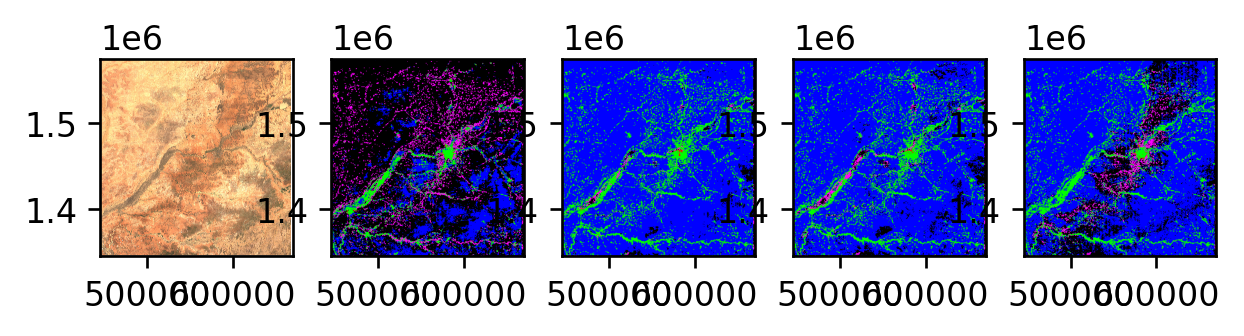

In [44]:
fig, axs = matPlt.subplots(1,5, dpi=240)
with rasterio.open(pathSatellite) as s:
  utils.displayTiles([s.read()], [s.transform],axs[0])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

axs[2].set_xlim(axs[0].get_xlim())
axs[2].set_ylim(axs[0].get_ylim())

axs[3].set_xlim(axs[0].get_xlim())
axs[3].set_ylim(axs[0].get_ylim())

axs[4].set_xlim(axs[0].get_xlim())
axs[4].set_ylim(axs[0].get_ylim())

resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, resultTest0, resultValid, lightMask)
utils.displayTiles([resultImg], [resultMeta], axs[1])
resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, resultTest1, resultValid, lightMask)
utils.displayTiles([resultImg], [resultMeta], axs[2])
resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, resultTest2, resultValid, lightMask)
utils.displayTiles([resultImg], [resultMeta], axs[3])
resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, resultTest3, resultValid, lightMask)
utils.displayTiles([resultImg], [resultMeta], axs[4])
